<a href="https://colab.research.google.com/github/mvgarcia/GarciaValentina_RECV_Entrega7/blob/main/GarciaValentina_RECV_Entrega7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
#-- Descomprimimos el dataset
#!rm -r fashion-mnistn
#!unzip fashion-mnist.zip

In [68]:

#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/8/45081.png'

In [69]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [70]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [71]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

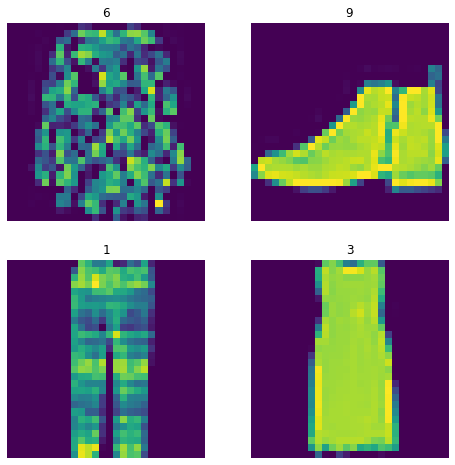

In [72]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [75]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

print(X_train.data.size())

batch_size = 64

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

torch.Size([55000, 28, 28])


# Descripción de la CNN

- Número de capas: 8
- Número de capas convolucionales: 3
- Número de capas Max pooling: 3
- Dropout: 3 veces con probabilidades de 0.3, 0.2, 0.3
- Número de características de las capas convolucionales: 28, 14, 7

In [98]:
#--- Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
  # ( (28-5+2*2)/1 ) + 1 = 28   -> 28*28*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 28/2 = 14                 -> 14*14*32

  torch.nn.Dropout(p=0.3),

  torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
  # ( (14-5+2*2)/1 ) + 1 = 14   -> 14*14*64

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 14/2 = 7                 -> 7*7*64

  torch.nn.Dropout(p=0.2), 

  torch.nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
  # ( (7-5+2*2)/1 ) + 1 = 7   -> 7*7*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 7/2 = 3                 -> 3*3*32

  torch.nn.Dropout(p=0.3), 

  torch.nn.Flatten(),
  torch.nn.Linear(3*3*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.3, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=288, out_features=10, bias=True)
)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


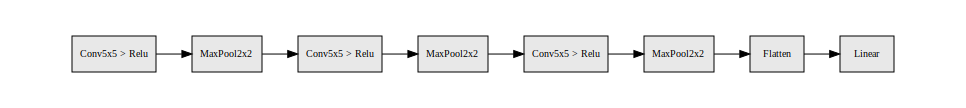

In [99]:
#--- Visualizamos la estructura de nuestra CNN

import hiddenlayer as hl

hl.build_graph(model, torch.zeros([64,1,28,28]))

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [96]:
#--- Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
  # ( (28-5+2*2)/1 ) + 1 = 28   -> 28*28*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 28/2 = 14                 -> 14*14*32

  torch.nn.Dropout(p=0.3),

  torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
  # ( (14-5+2*2)/1 ) + 1 = 14   -> 14*14*64

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 14/2 = 7                 -> 7*7*64

  torch.nn.Dropout(p=0.2), 

  torch.nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
  # ( (7-5+2*2)/1 ) + 1 = 7   -> 7*7*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 7/2 = 3                 -> 3*3*32

  torch.nn.Dropout(p=0.3), 

  torch.nn.Flatten(),
  torch.nn.Linear(3*3*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.3, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=288, out_features=10, bias=True)
)

In [ ]:
#!pip install hiddenlayer

In [102]:
n_epoch*len(train_dl)

8600

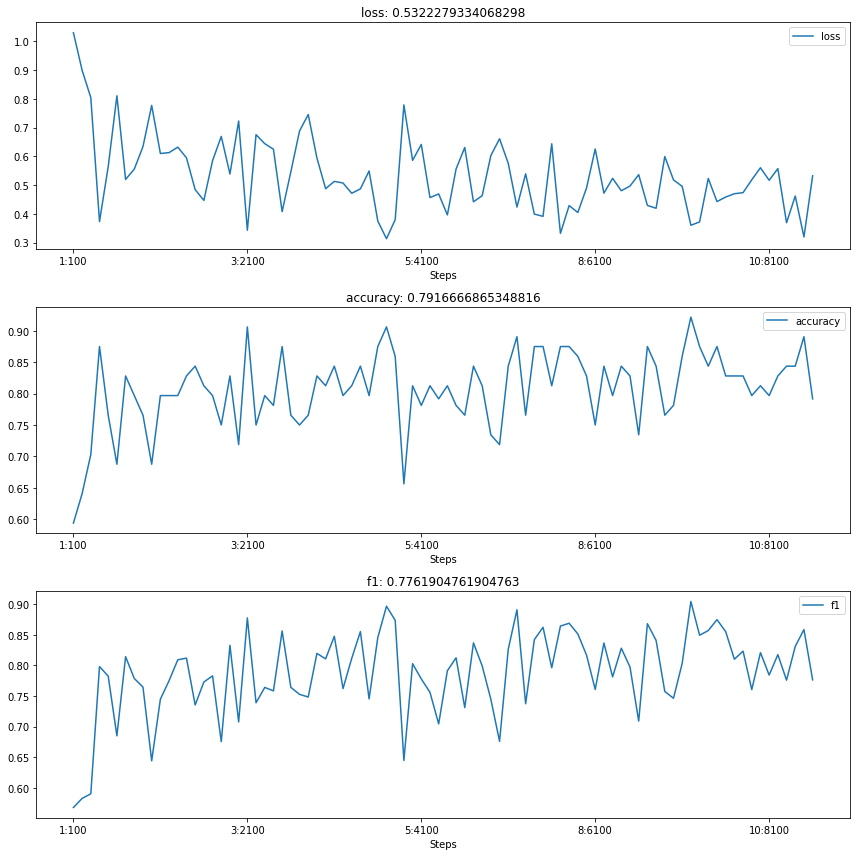

In [100]:
#-- Cargamos el modelo en la GPU
model.to(device)

from tqdm.notebook import tqdm

n_epoch = 10

pbar = tqdm(total=n_epoch*len(train_dl))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)



history2 = hl.History()
canvas2 = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%100 == 0:
        history2.log((epoch+1, iter), loss=loss, accuracy=acc, f1=f1)
        with canvas2:
          canvas2.draw_plot(history2["loss"])
          canvas2.draw_plot(history2["accuracy"])
          canvas2.draw_plot(history2["f1"])

    pbar.update()
pbar.close()

In [ ]:
"""#--- Entrenamos la CNN

from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

n_epoch = 10

pbar = tqdm(total=n_epoch*len(train_dl))

print(n_epoch*len(train_dl))

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    #print(X_train_batch.size())
    Xtr = X_train_batch.unsqueeze(1)
    #print(Xtr.size())
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%100 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1"])
    pbar.update()
pbar.close()"""

32


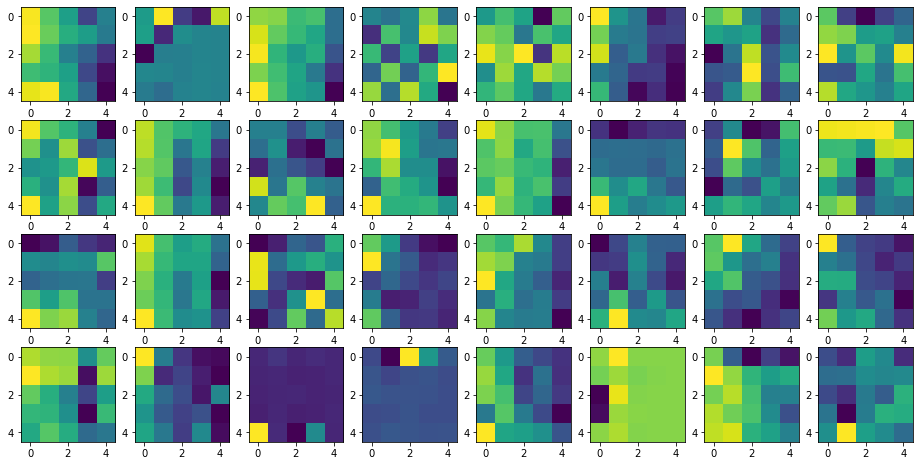

In [101]:
#-- Visualizando los mapas de características de la primera capa convolucional
kernels = list(model.children())[4].weight.detach()

fig = plt.figure(figsize=(16,8))
k = 0
print(kernels[0].size(0))
for i in range(kernels[0].size(0)):
    plt.subplot(4,8,k+1)
    plt.imshow(kernels[0][i].cpu().squeeze())
    k += 1
plt.show()

#Resultados

In [103]:
#-- Matriz de confusión
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

Loss:0.49, F1:0.82, Acc:0.82


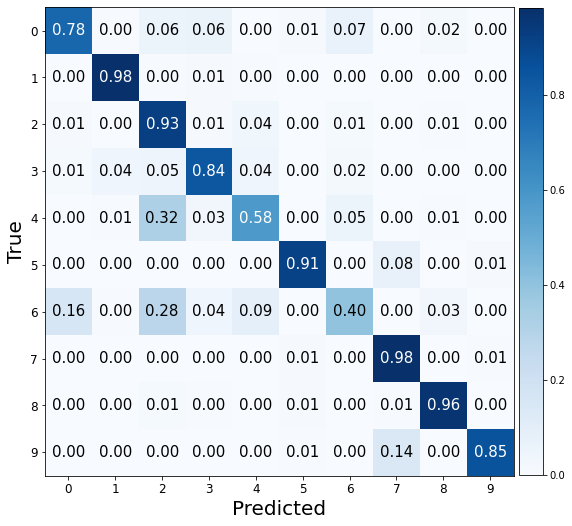

In [105]:
#-- Validamos el modelo

X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Y_pred = Y_pred.to(device)

CM(Y_valid.cpu(), Y_pred.cpu(), 10)

#Resultados obtenidos:

- Loss: 0.49
- Acc: 0.82
- F1: 0.82

De esto deducimos que el modelo no es tan bueno debido a que tiene un Loss muy alto(0.49). Sin embargo, tiene unos F1 y Accuracy muy aceptables (0.82), lo que quiere decir que el modelo acerta un una gran parte de los casos.

De la matriz de confusión de la celda anterior, vemos que el modelo tiene unos resultados aceptables en la mayoría de las prendas. La que mejor se predice es el "1:Trouser" y "7:Sneaker" y el peor es el "6:Shirt". La confusión más grande se da al predecir "2:Pullover" cuando realmente es "4:Coat".